In [1]:
from SeqReader import seqFileHandler

import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import gridspec
from matplotlib.ticker import StrMethodFormatter

import re
import warnings

np.set_printoptions(formatter={'float':lambda x: f'{x:0.2f}'})

In [2]:
def plotSpacialDist(lineList,image,imageFilename=None,imageFolder='./',wratio=1.25,wspace=0,ylimit=[0,220],yLabelPos=0.51):
    '''
    This function generates spacial distribution of greyscale values of the pixels in the provided `image` (greyscale only) along the lines provided in the `lineList`. 
    
    If `imageFilename` provided, then the resulting image will be exported to file (if `imageFilename` provided without extension, then '.png' extension will be added).
    
    Inputs:
        - `lineList`: a list of arrays (or lists) with 4 values each with the following structure with 4 (four) integer values: [startX,startY,endX,endY], where:
            - startX,startY - x and y coordinates of the start of the line
            - endX,endY - x and y coordinates of the end of the line.
            If any of the values will be less than zero or larger than the corresponding size of the `image` it will be clipped.
        - `image`: 2D numpy array with values of actual greyscale values of the image to be analysed. Tested only with 8 bit images.
        - `imageFilename` - `str` or None. When None, no image will be exported. When `str`, the resulting image with displayed image itself and greyscale distributions 
            over all provided lines will be exported to the file with the name provided. Only export in PNG is currently supported. The function will check if it has 
            a '.png' extension. If it does not, it will be added automatically. If it is not None and not 'str', the Warning will be raised and nothing will be exported.
        - `imageFolder` - `str`. Provide alternative path to save images to. Default is current directory.
    Outputs:
        The function does not return any values.
    '''
    
    numLines=len(lineList)
    cmap = plt.cm.jet
    colours = cmap(np.arange(numLines)/(numLines-1))

    fig = plt.figure(figsize=(20,11))
    gs1 = gridspec.GridSpec(numLines,2,width_ratios=[wratio,1],wspace=wspace,hspace=0)
    
    
    ax1 = fig.add_subplot(gs1[:,0])

    ax1.imshow(image,cmap=plt.cm.gray)
    for i,lineArray in enumerate(lineList):
        lineArray[[0,2]] = np.clip(lineArray[[0,2]],0,image.shape[1]-1)
        lineArray[[1,3]] = np.clip(lineArray[[1,3]],0,image.shape[0]-1)
        ax1.plot([lineArray[0],lineArray[2]],[lineArray[1],lineArray[3]],c=colours[i],linewidth=4,label=f'Line probe {i+1:02d}')
        x = np.arange(np.max([np.abs(lineArray[0]-lineArray[2]),np.abs(lineArray[1]-lineArray[3])]),dtype=np.int)
        y = image[np.floor(lineArray[1]+(x/(x.shape[0]-1))*(lineArray[3]-lineArray[1])).astype(np.int),
                  np.floor(lineArray[0]+(x/(x.shape[0]-1))*(lineArray[2]-lineArray[0])).astype(np.int)]
        ax = fig.add_subplot(gs1[i,1])
        ax.autoscale(axis='x',tight=True)
        ax.plot(x,y,c=colours[i])
        ax.set_ylim(ylimit)
        yRange=(np.max(ylimit)-np.min(ylimit))
        ax.set_yticks(np.linspace(np.min(ylimit)+yRange*0.1,np.max(ylimit)-yRange*0.1,num=5))
        ax.set_xticks([])
        [aaa.set_linewidth(2) for aaa in ax.spines.values()]
        ax.spines['bottom'].set_bounds(x[0]-(x[-1]-x[0])*0.05,x[-1])
        ax.spines['top'].set_bounds(x[0]-(x[-1]-x[0])*0.05,x[-1])
        ax.tick_params(axis='both', which='major', labelsize=18)
        
    ax.set_xticks(x[np.linspace(0,x.shape[0]-1,num=6,dtype=np.int)])
    ax.set_xticklabels([f'{x:0.2f}' for x in np.linspace(0,1,num=6,dtype=np.float32)])
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.legend(prop={'size': 18})
    
    fig.text(yLabelPos,0.5,'Intensity (greyscale)',va='center',rotation='vertical',size=20)
    fig.text(0.72,0.06,'Normalised distance',ha='center',size=20)
    
    defaultExtension = 'png'
    if imageFilename:
        if type(imageFilename) is str:
            if re.match(f'.*\.{defaultExtension}$',imageFilename):
                plt.savefig(f'{imageFolder}{imageFilename}',bbox_inches="tight")
            else:
                plt.savefig(f'{imageFolder}{imageFilename}.{defaultExtension}',bbox_inches="tight")
        else:
            if type(imageFileName) is not str:
                warnings.warn(f'`imageFilename can only be string, but {type(imageFilename)} provided. Image was not exported.`')
            if type(imageFolder) is not str:
                warnings.warn(f'`imageFolder can only be string, but {type(imageFolder)} provided. Image was not exported.`')

In [3]:
def plotTemporalDist(pointsList,images,imageFilename=None,imageFolder='./',wratio=1.25,wspace=0,yLabelPos=0.505):
    '''
    This function generates temporal distribution of greyscale values of the pixels in the provided set of images in `image` (greyscale only) along the time at points provided  in the `pointsList`. 
    
    If `imageFilename` provided, then the resulting image will be exported to file (if `imageFilename` provided without extension, then '.png' extension will be added).
    
    Inputs:
        - `pointsList`: a list of arrays (or lists) with 2 values each with the following structure with 2 (two) integer values: [X,Y] that represent coordinates of a point where the temporal distribution is calculated
            If any of the values will be less than zero or larger than the corresponding size of the `image` it will be clipped.
        - `images`: 3D numpy array (BxHxW, B - batch dimension, or number of frame, H and W - height and width of the frame) with values of actual greyscale values of the images to be analysed. works only with 8 bit images.
        - `imageFilename` - `str` or None. When None, no image will be exported. When `str`, the resulting image with displayed image itself and greyscale distributions 
            over all provided lines will be exported to the file with the name provided. Only export in PNG is currently supported. The function will check if it has 
            a '.png' extension. If it does not, it will be added automatically. If it is not None and not 'str', the Warning will be raised and nothing will be exported.
        - `imageFolder` - `str`. Provide alternative path to save images to. Default is current directory.
    Outputs:
        - `meanList`: Mean greyscale value for each point probe.
        - `stdList`: Standard deviation of the greyscale values for each point probe.
        - `rangeList`: The range of the greyscale values for each point probe.
    '''
    
    rangeList = []
    meanList = []
    stdList = []
    
    numPoints=len(pointList)
    numFrames = images.shape[0]
    cmap = plt.cm.jet
    colours = cmap(np.arange(numPoints)/(numPoints-1))

    fig = plt.figure(figsize=(20,11))
    gs1 = gridspec.GridSpec(numPoints,2,width_ratios=[wratio,1],wspace=wspace,hspace=0)
    
    ax1 = fig.add_subplot(gs1[:,0])

    ax1.imshow(np.mean(images,axis=0),cmap=plt.cm.gray)
    for i,point in enumerate(pointsList):
        point[0] = np.clip(point[0],0,images.shape[2])
        point[1] = np.clip(point[1],0,images.shape[1])
        point = point.astype(np.int)
        ax1.plot([point[0]],[point[1]],c=colours[i],markersize=10,marker='x',linewidth=0,label=f'Point probe {i+1:02d}')
        x = np.arange(numFrames,dtype=np.int)
        y = images[:,point[1],point[0]]
        ax = fig.add_subplot(gs1[i,1])
        ax.autoscale(axis='x',tight=True)
        ax.plot(x,y,c=colours[i])
        yRange=(np.max(y)-np.min(y))
        rangeList.append(yRange)
        ax.set_yticks(np.linspace(np.min(y)+yRange*0.1,np.max(y)-yRange*0.1,num=5))
        [aaa.set_linewidth(2) for aaa in ax.spines.values()]
        ax.spines['bottom'].set_bounds(x[0]-(x[-1]-x[0])*0.05,x[-1])
        ax.spines['top'].set_bounds(x[0]-(x[-1]-x[0])*0.05,x[-1])
        ax.tick_params(axis='both', which='major', labelsize=18)

        meanValue = y.mean()
        meanList.append(meanValue)
        stdValue = y.std()
        stdList.append(stdValue)
        ax.plot([x.min(),x.max()],[meanValue,meanValue],'k-')
        ax.plot([x.min(),x.max()],[meanValue+stdValue,meanValue+stdValue],'k--')
        ax.plot([x.min(),x.max()],[meanValue-stdValue,meanValue-stdValue],'k--')
        ax.set_xticks([])
        
        
    ax.set_xticks(x[np.linspace(0,x.shape[0]-1,num=11,dtype=np.int)])
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.legend(prop={'size': 18})
    fig.text(yLabelPos,0.5,'Intensity (greyscale)',va='center',rotation='vertical',size=20)
    fig.text(0.72,0.06,'Frame number',ha='center',size=20)
    
    defaultExtension = 'png'
    if imageFilename:
        if type(imageFilename) is str and type(imageFolder) is str:
            if re.match(f'.*\.{defaultExtension}$',imageFilename):
                plt.savefig(f'{imageFolder}{imageFilename}',bbox_inches="tight")
            else:
                plt.savefig(f'{imageFolder}{imageFilename}.{defaultExtension}',bbox_inches="tight")
        else:
            if type(imageFileName) is not str:
                warnings.warn(f'`imageFilename can only be string, but {type(imageFilename)} provided. Image was not exported.`')
            if type(imageFolder) is not str:
                warnings.warn(f'`imageFolder can only be string, but {type(imageFolder)} provided. Image was not exported.`')
    
    return (meanList,stdList,rangeList)

In [4]:
def plotImageHistogram(image,aCrd=None,imageFilename=None,imageFolder='./'):
    '''
    This function generates histogram of greyscale values of the pixels in the provided `image` (greyscale only). 
    
    If `imageFilename` provided, then the resulting image will be exported to file (if `imageFilename` provided without extension, then '.png' extension will be added).
    
    Inputs:
        - `image`: 2D numpy array (HxW, H and W - height and width of the frame) with values of actual greyscale values of the image to be analysed. Works only with 8 bit images.
        - `imageFilename` - `str` or None. When None, no image will be exported. When `str`, the resulting image with displayed image itself and greyscale distributions 
            over all provided lines will be exported to the file with the name provided. Only export in PNG is currently supported. The function will check if it has 
            a '.png' extension. If it does not, it will be added automatically. If it is not None and not 'str', the Warning will be raised and nothing will be exported.
        - `imageFolder` - `str`. Provide alternative path to save images to. Default is current directory.
    Outputs:
        The function does not return any values.
    '''
    
    cmap = plt.cm.gray
    hist,bins = np.histogram(image,bins=np.arange(0,257,2),normed=True)
    binCentres = (bins[1:]+bins[:-1])/2
    colours = cmap(binCentres/270)
    plt.figure(figsize=(20,8))
    plt.gca().autoscale(axis='x',tight=True)
    plt.bar(binCentres,hist,(bins[0]+bins[1])*0.8,color=colours)
    plt.xticks(binCentres[::5])
    
    plt.gca().tick_params(axis='both', which='major', labelsize=18)
    plt.ylim([0,0.045])
    plt.xlabel('Intensity (greyscale)',size=20)
    
    if aCrd is not None:
        if len(aCrd)%3==0:
            n = len(aCrd)//3
            for i in range(n):
                plt.annotate(s=aCrd[i*3],xy=aCrd[i*3+1],xytext=aCrd[i*3+2],arrowprops={'arrowstyle': '->'},fontsize=18)
    
    defaultExtension = 'png'
    if imageFilename:
        if type(imageFilename) is str and type(imageFolder) is str:
            if re.match(f'.*\.{defaultExtension}$',imageFilename):
                plt.savefig(f'{imageFolder}{imageFilename}',bbox_inches="tight")
            else:
                plt.savefig(f'{imageFolder}{imageFilename}.{defaultExtension}',bbox_inches="tight")
        else:
            if type(imageFileName) is not str:
                warnings.warn(f'`imageFilename can only be string, but {type(imageFilename)} provided. Image was not exported.`')
            if type(imageFolder) is not str:
                warnings.warn(f'`imageFolder can only be string, but {type(imageFolder)} provided. Image was not exported.`')
    
    
    plt.show()

In [5]:
def plotBlob3DMap(pointsList,images,imageBasename=None,imageFolder='./',doPixels=False):
    '''
    This function generates 3D map of the mosquito blobs. Coordinates and sizes of the blobs provided in the 'pointsList' and images are provided in the 3D array 'images'. \
    References to respective image number will also be provided in the points list. The function also returns an array of the greyscale values in the centre of the blob \
    (coordinates provided by pointsList).
    
    If `imageBasename` provided, then the resulting images will be exported to files which will be named as '{imageBasename}_{pointIndex}.png'. `pointIndex` is a consecutive \
    number of the image in the pointsList.
    
    Inputs:
        - `pointsList`: a list of arrays (or lists) with 4 values each with the following structure with 4 (four) integer values: [X,Y,Size,imageIndex] that represent \
        coordinates of a point (X,Y), size of the square to plot (Size x Size) and index of the frame to use in `images` array.
            If any of the values will be less than zero or larger than the corresponding size of the `image` it will be clipped.
        - `images`: 3D numpy array (BxHxW, B - batch dimension, or number of frame, H and W - height and width of the frame) with values of actual greyscale values of \
        the images to be analysed. works only with 8 bit images.
        - `imageBasename` - `str` or None. When None, no image will be exported. When `str`, the resulting 3D map image of each blob will be saved into file \
        '{imageBasename}_{pointIndex}.png'.
        - `imageFolder` - `str`. Provide alternative path to save images to. Default is current directory.
    Outputs:
        - A 1D array the same size as the length of the `pointsList` with greyscale values of the centres of the blobs.
    '''
    if imageBasename:
        if type(imageBasename) is not str:
            warnings.warn(f'`imageBasename can only be string, but {type(imageBasename)} provided. Image was not exported.`')
            imageBasename=None
        if type(imageFolder) is not str:
            warnings.warn(f'`imageFolder can only be string, but {type(imageFolder)} provided. Image was not exported.`')
            imageFolder='./'
        
            
    numPoints=len(pointList)
    numFrames = images.shape[0]
    
    gvCentres=[]
    for i,point in enumerate(pointsList):
        x=point[0]
        y=point[1]
        size=point[2]
        image=images[point[3],:,:]
        gv = image[y,x]
        gvCentres.append(gv)
        xl=np.arange(y-np.int(size/2),y+np.int(size/2)+1)
        yl=np.arange(x-np.int(size/2),x+np.int(size/2)+1)
        x3,y3=np.mgrid[y-np.int(size/2):y+np.int(size/2)+1,x-np.int(size/2):x+np.int(size/2)+1]
        blob = image[x3,y3]
        fig = plt.figure(figsize=(20,10))
        gs1 = gridspec.GridSpec(2,2,width_ratios=[1.5,1],height_ratios=[15,1],wspace=0.1,hspace=0.1)
        # x3,y3 = np.mgrid[y-np.int(size/2):y+np.int(size/2)+1,x-np.int(size/2):x+np.int(size/2)+1]

        xStep = np.int(np.round((xl.shape[0])/6))
        xStep = 1 if xStep==0 else xStep
        yStep = np.int(np.round((yl.shape[0])/6))
        yStep = 1 if yStep==0 else yStep
        zStep = np.int(np.round((blob.max()-blob.min())/25))
        zStep = 1 if zStep==0 else zStep
        
        ax = fig.add_subplot(gs1[0,0],projection='3d')
        if doPixels:
            x3B = x3.ravel()
            y3B = y3.ravel()
            blobB = blob.ravel()
            bottom = np.zeros_like(blobB)
            cmap = plt.cm.gray
            colours = cmap((blobB-blobB.min())/(blobB.max()-blobB.min()))
            im = ax.bar3d(x3B,y3B,bottom,1,1,blobB.max() - blobB,colours,shade=True)
            ax.tick_params(axis='both', which='major', labelsize=18)
            ax.xaxis.set_ticks(xl[::xStep])
            ax.xaxis.set_ticklabels(xl[::xStep]-np.min(xl))
            ax.yaxis.set_ticks(yl[::yStep])
            ax.yaxis.set_ticklabels(yl[::yStep]-np.min(yl))
            ax.zaxis.set_ticks(np.round(np.linspace(0,blob.max()-blob.min(),num=5)))
            ax.zaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
            ax.set_zticklabels(np.flip(np.round(np.linspace(blob.min(),blob.max(),num=5)).astype(np.int),axis=0))
        else:
            im = ax.plot_surface(x3,y3,blob,cmap=plt.cm.gray)
            ax.tick_params(axis='both', which='major', labelsize=18)
            ax.xaxis.set_ticks(xl[::xStep])
            ax.yaxis.set_ticks(yl[::yStep])
            ax.invert_zaxis()
        ax.view_init(20, 160)

        ax2 = fig.add_subplot(gs1[0,1])
        if doPixels:
            im2 = ax2.matshow(blob,cmap=plt.cm.gray)
            ax2.tick_params(axis='both', which='major', labelsize=18)
            ax2.xaxis.set_ticks(np.arange(0,blob.shape[0])[::xStep])
            ax2.yaxis.set_ticks(np.arange(0,blob.shape[1])[::yStep])
            ax2.set_xticklabels(xl[::xStep]-np.min(xl))
            ax2.set_yticklabels(yl[::yStep]-np.min(yl))
        else:
            ax.tick_params(axis='both', which='major', labelsize=18)
            im2 = ax2.contourf(x3,y3,blob,cmap=plt.cm.gray)
        ax3 = fig.add_subplot(gs1[1,:])
        ax3.tick_params(axis='both', which='major', labelsize=18)
        cbar = plt.colorbar(im2,cax=ax3,orientation='horizontal')
        cbar.set_label('Intensity (greyscale)',size=20)
        
        if imageBasename:
            plt.savefig(f'{imageFolder}{imageBasename}_{i+1:02d}.png',bbox_inches="tight")
        plt.show()
    
    return np.array(gvCentres)    

# Analysis of illumination

In [6]:
baseDir = './IlluminationData/'

## Gates system

In [7]:
seq1File = 'reducedRRS.seq'

seq1 = seqFileHandler(baseDir+seq1File)

In [8]:
startFrame=100
endFrame=349
images1 = seq1.readFrames(startFrame=startFrame,endFrame=endFrame).numpy()
images1.shape

(250, 3000, 2300)

In [9]:
image1 = images1[-1,:,:]
image1.shape

(3000, 2300)

In [10]:
lineList = []
lineArray1 = np.array([np.floor(seq1.imageWidth/2),np.floor(seq1.imageHeight/2-250),np.floor(seq1.imageWidth),np.floor(seq1.imageHeight/2-250)])
lineList.append(lineArray1)
lineArray2 = np.array([np.floor(seq1.imageWidth/2),np.floor(seq1.imageHeight/2-250),np.floor(seq1.imageWidth/2),0])
lineList.append(lineArray2)
lineArray3 = np.array([np.floor(seq1.imageWidth/2),np.floor(seq1.imageHeight/2-250),np.floor(seq1.imageWidth),0])
lineList.append(lineArray3)

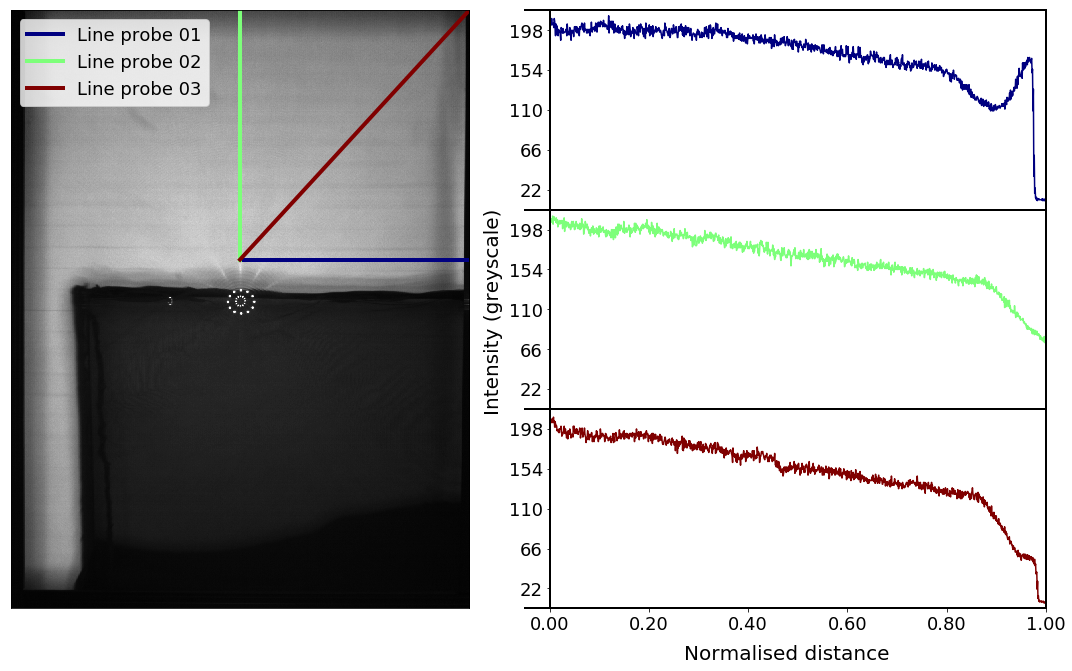

In [11]:
plotSpacialDist(lineList,image1,imageFilename='Gates_bright.png',imageFolder='./Images/',ylimit=[0,220])

In [12]:
lineList2 = []
lineArray1 = np.array([np.floor(seq1.imageWidth/2),np.floor(seq1.imageHeight/2+100),seq1.imageWidth,np.floor(seq1.imageHeight/2+100)])
lineList2.append(lineArray1)
lineArray2 = np.array([np.floor(seq1.imageWidth/2),np.floor(seq1.imageHeight/2+100),np.floor(seq1.imageWidth/2),seq1.imageHeight])
lineList2.append(lineArray2)
lineArray3 = np.array([np.floor(seq1.imageWidth/2),np.floor(seq1.imageHeight/2+100),seq1.imageWidth,seq1.imageHeight])
lineList2.append(lineArray3)

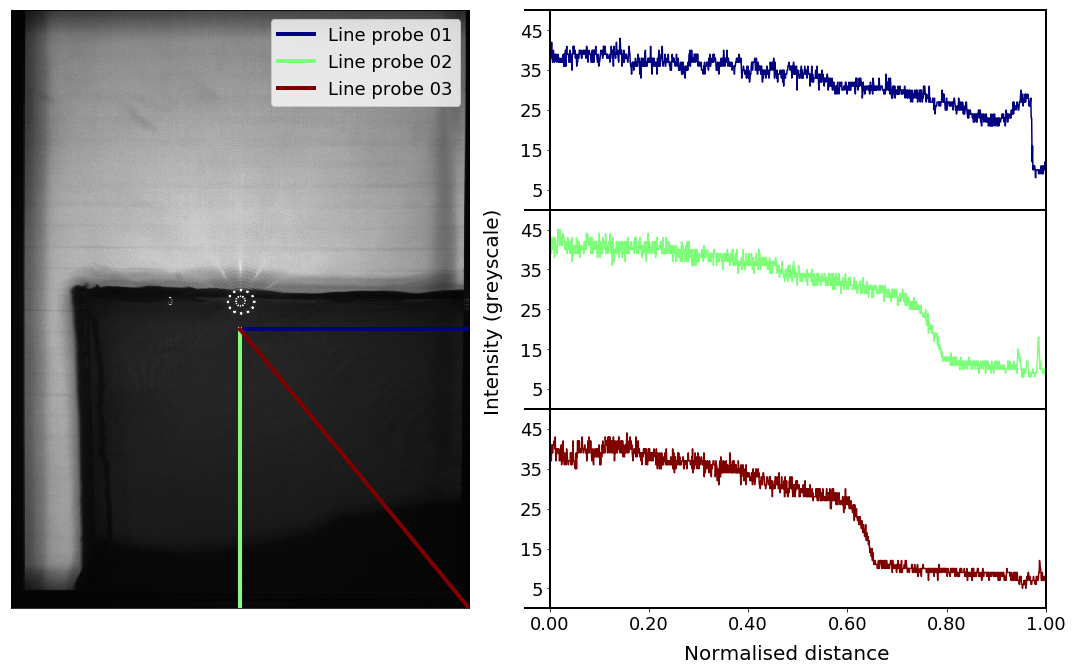

In [13]:
plotSpacialDist(lineList2,image1,imageFilename='Gates_dark.png',imageFolder='./Images/',ylimit=[0,50])

In [14]:
pointList = []
point2 = np.array([np.floor(seq1.imageWidth/2),np.floor(seq1.imageHeight/4)])
pointList.append(point2)
point1 = np.array([np.floor(seq1.imageWidth/2),np.floor(seq1.imageHeight*3/4)])
pointList.append(point1)
point3 = np.array([np.floor(seq1.imageWidth*3/4),np.floor(seq1.imageHeight*3/4)])
pointList.append(point3)
point4 = np.array([np.floor(seq1.imageWidth*3/4),np.floor(seq1.imageHeight/4)])
pointList.append(point4)

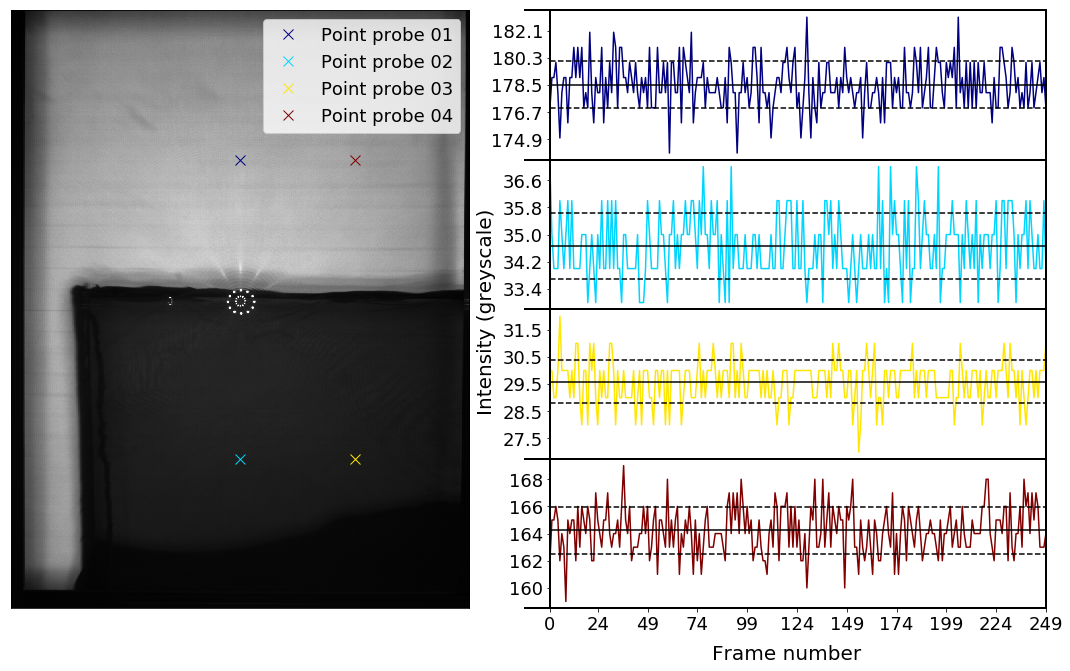

In [15]:
gatesTempStats = plotTemporalDist(pointList,images1,'Gates_temporal.png',imageFolder='./Images/')

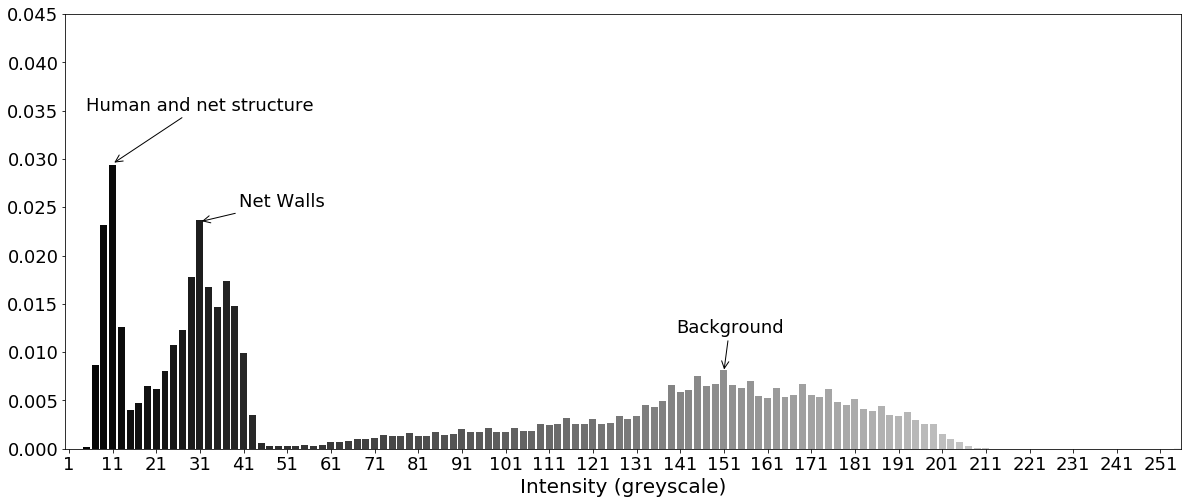

In [16]:
annCoords = ['Human and net structure',(11,0.0295),(5,0.035),'Net Walls',(31,0.0235),(40,0.025),'Background',(151,0.008),(140,0.012)]
plotImageHistogram(image1,aCrd=annCoords,imageFilename='Gates_histogram.png',imageFolder='./Images/')

In [17]:
imagesB1 = []
imagesB1.append(seq1.readFrame(462).numpy())
imagesB1.append(seq1.readFrame(441).numpy())
imagesB1.append(seq1.readFrame(430).numpy())
imagesB1 = np.stack(imagesB1,axis=0)

pointsList=[]
pointsList.append(np.array([467,932,20,0]))
pointsList.append(np.array([559,1249,20,1]))
pointsList.append(np.array([620,1370,20,2]))

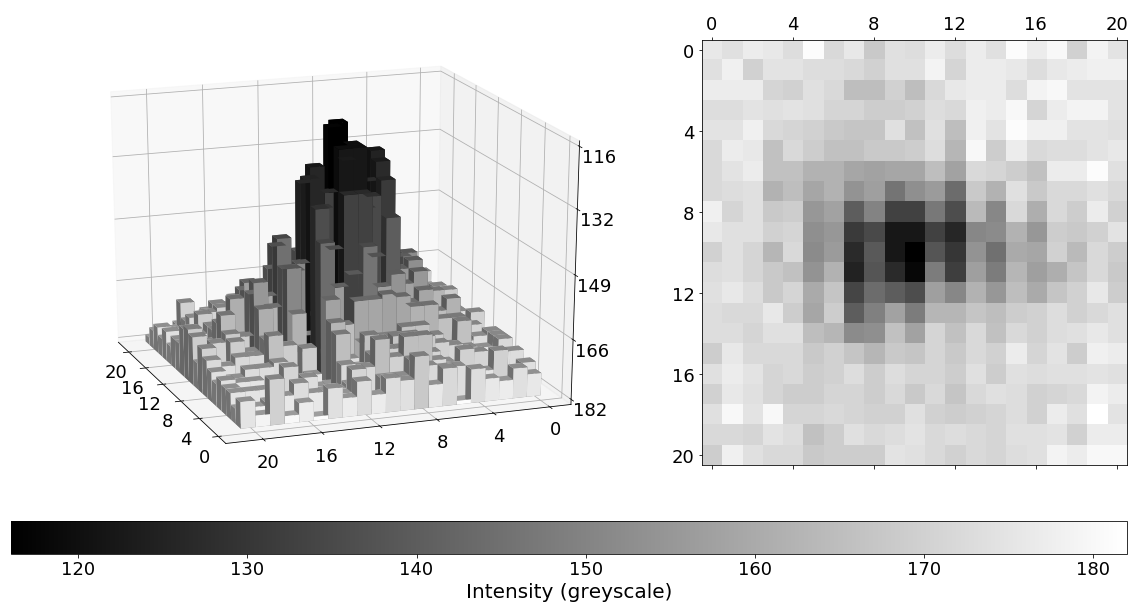

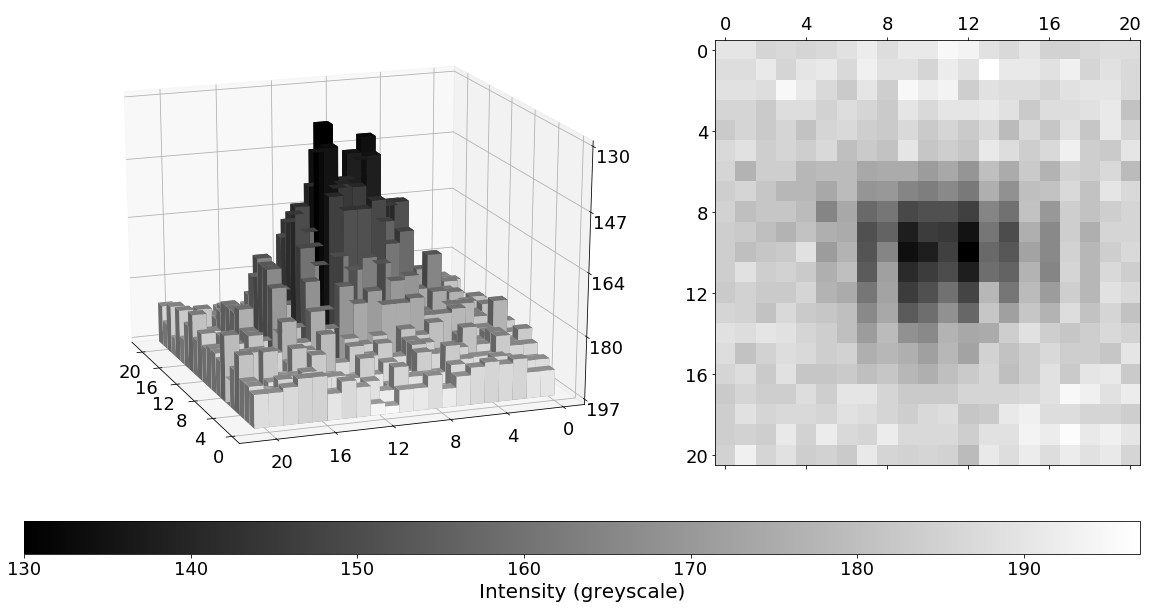

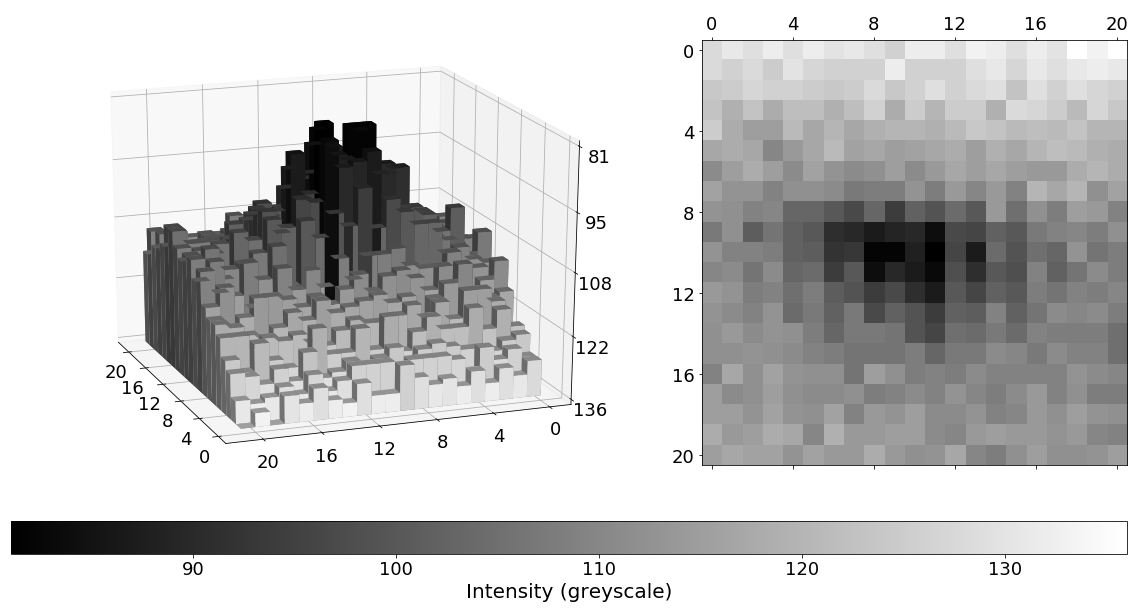

In [18]:
dvCentres_gates_bright = plotBlob3DMap(pointsList,imagesB1,imageBasename='Gates_bright',imageFolder='./Images/',doPixels=True)

In [19]:
imagesB1 = []
imagesB1.append(seq1.readFrame(412).numpy())
imagesB1.append(seq1.readFrame(384).numpy())
imagesB1.append(seq1.readFrame(337).numpy())
imagesB1.append(seq1.readFrame(328).numpy())
imagesB1 = np.stack(imagesB1,axis=0)

pointsList=[]
pointsList.append(np.array([741,1560,20,0]))
pointsList.append(np.array([874,2040,20,1]))
pointsList.append(np.array([930,2525,20,2]))
pointsList.append(np.array([915,2692,20,3]))

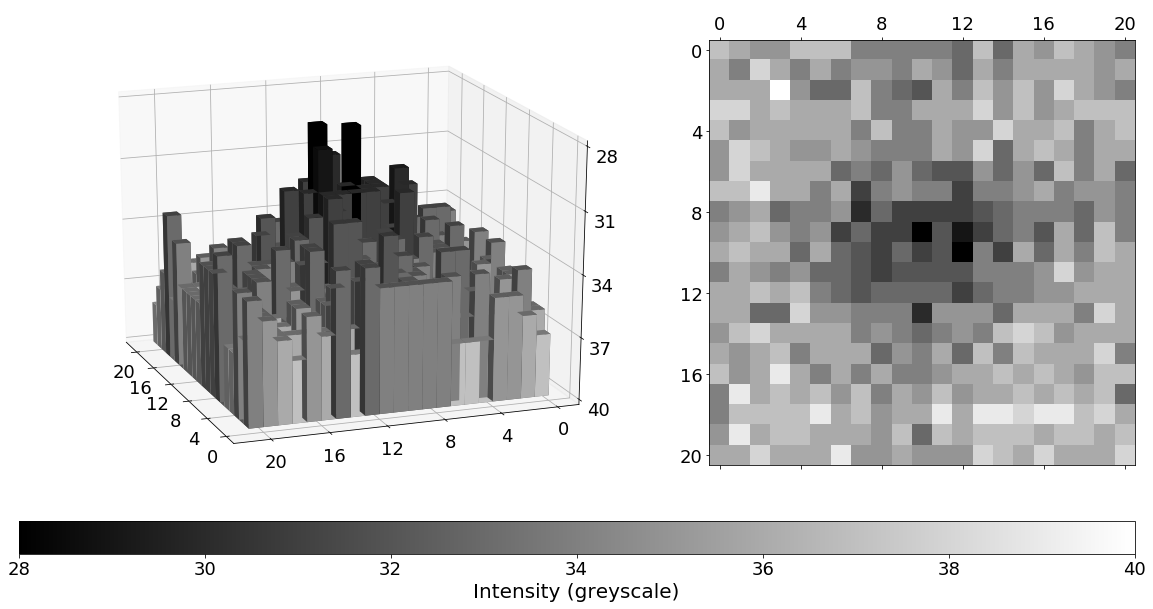

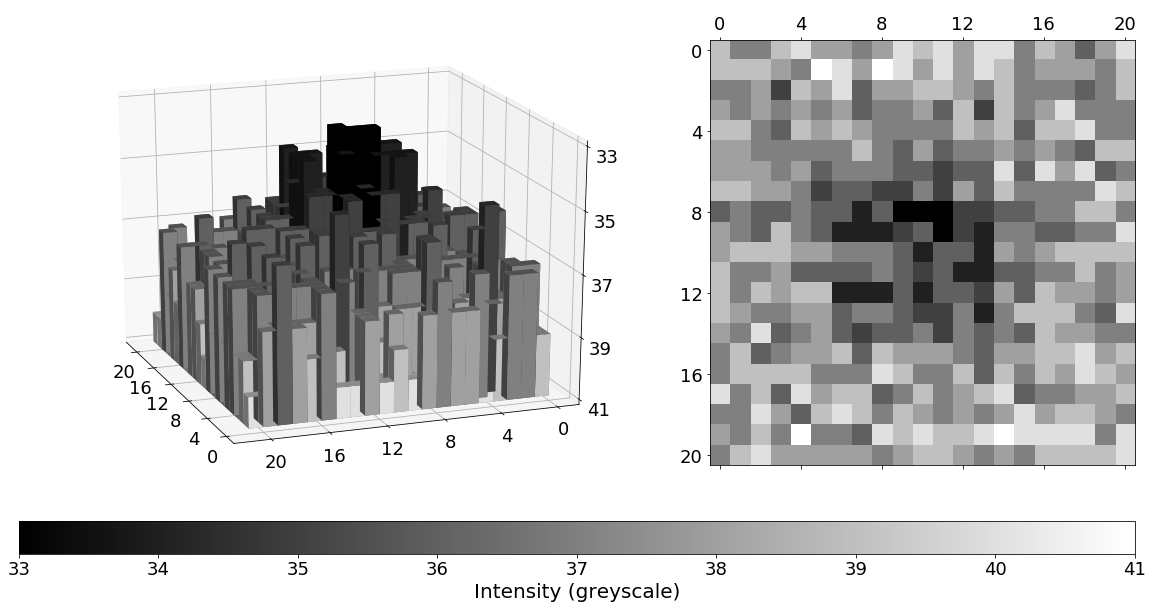

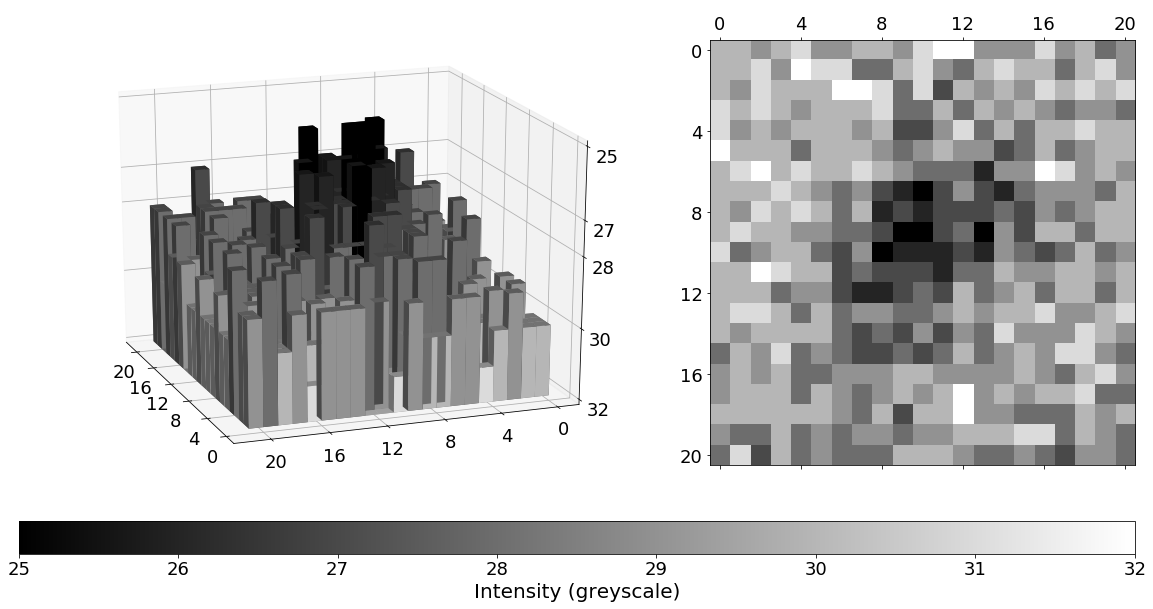

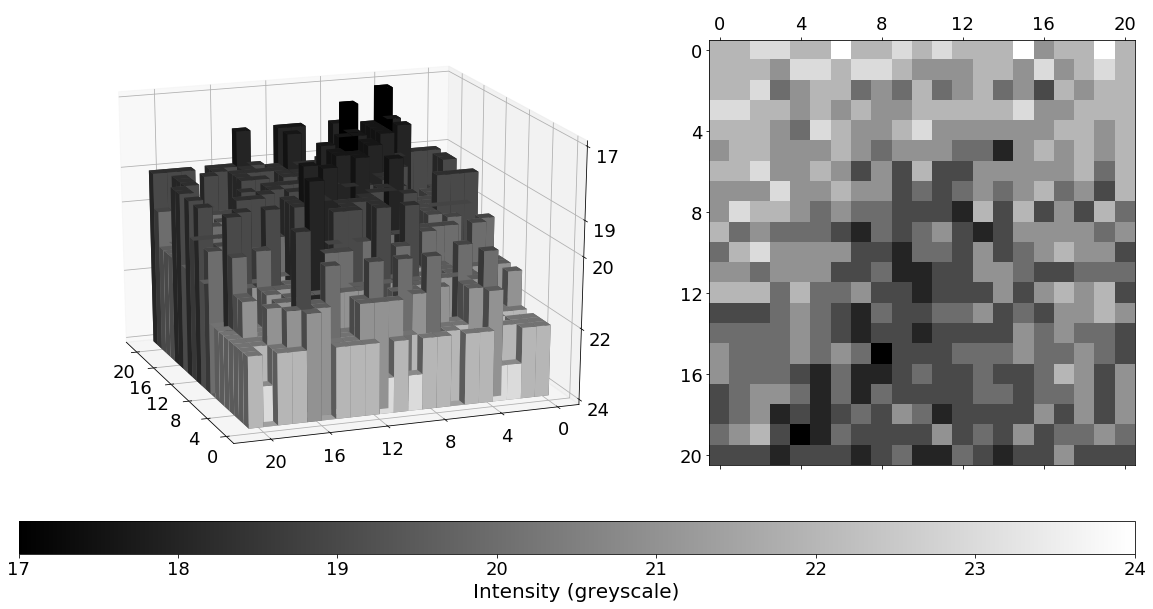

In [20]:
dvCentres_gates_net = plotBlob3DMap(pointsList,imagesB1,imageBasename='Gates_net',imageFolder='./Images/',doPixels=True)

## Backlit system

In [21]:
seq1File = 'backlit.seq'

seq3 = seqFileHandler(baseDir+seq1File)

In [22]:
startFrame=100
endFrame=349
images3 = seq3.readFrames(startFrame=startFrame,endFrame=endFrame).numpy()
images3.shape

(250, 2048, 2048)

In [23]:
image3 = images3[-1,:,:]
image3.shape

(2048, 2048)

In [24]:
lineList = []
lineArray1 = np.array([np.floor(seq3.imageWidth/2+50),np.floor(seq3.imageHeight/2-150),np.floor(seq3.imageWidth),np.floor(seq3.imageHeight/2-150)])
lineList.append(lineArray1)
lineArray2 = np.array([np.floor(seq3.imageWidth/2+50),np.floor(seq3.imageHeight/2-150),np.floor(seq3.imageWidth/2+50),0])
lineList.append(lineArray2)
lineArray3 = np.array([np.floor(seq3.imageWidth/2+50),np.floor(seq3.imageHeight/2-150),np.floor(seq3.imageWidth),0])
lineList.append(lineArray3)

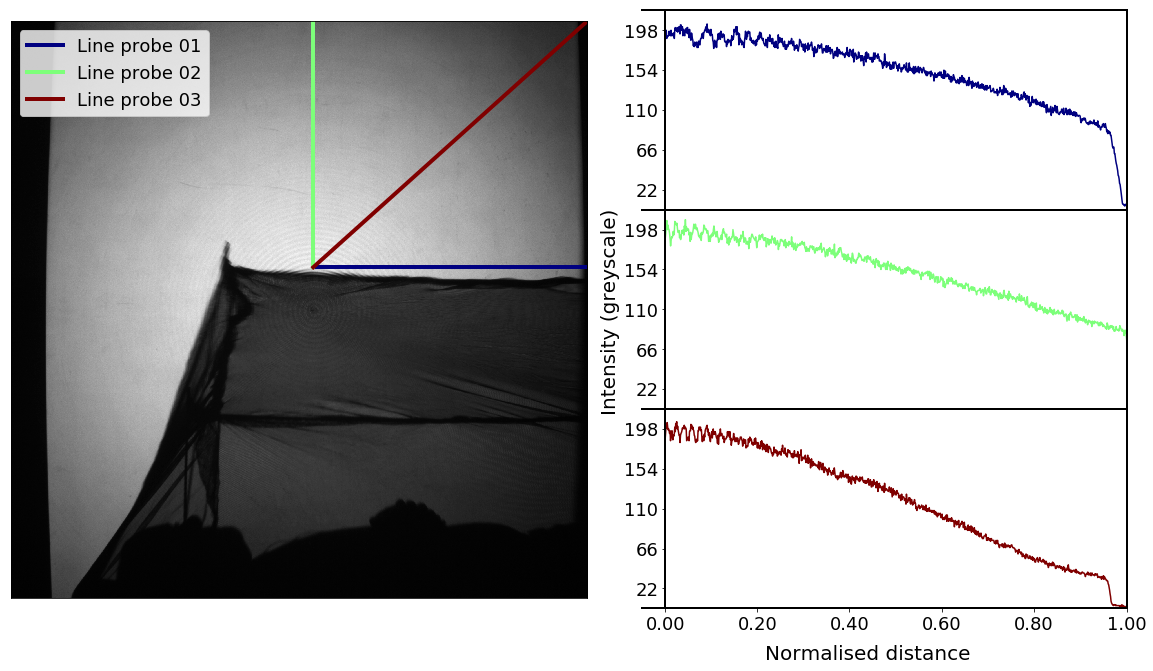

In [25]:
plotSpacialDist(lineList,image3,imageFilename='backlit_bright.png',imageFolder='./Images/',wspace=0.15,yLabelPos=0.535)

In [26]:
lineList2 = []
lineArray1 = np.array([np.floor(seq3.imageWidth/2+50),np.floor(seq3.imageHeight/2),seq3.imageWidth,np.floor(seq3.imageHeight/2)])
lineList2.append(lineArray1)
lineArray2 = np.array([np.floor(seq3.imageWidth/2+50),np.floor(seq3.imageHeight/2),np.floor(seq3.imageWidth/2+50),seq3.imageHeight])
lineList2.append(lineArray2)
lineArray3 = np.array([np.floor(seq3.imageWidth/2+50),np.floor(seq3.imageHeight/2),seq3.imageWidth,seq3.imageHeight])
lineList2.append(lineArray3)

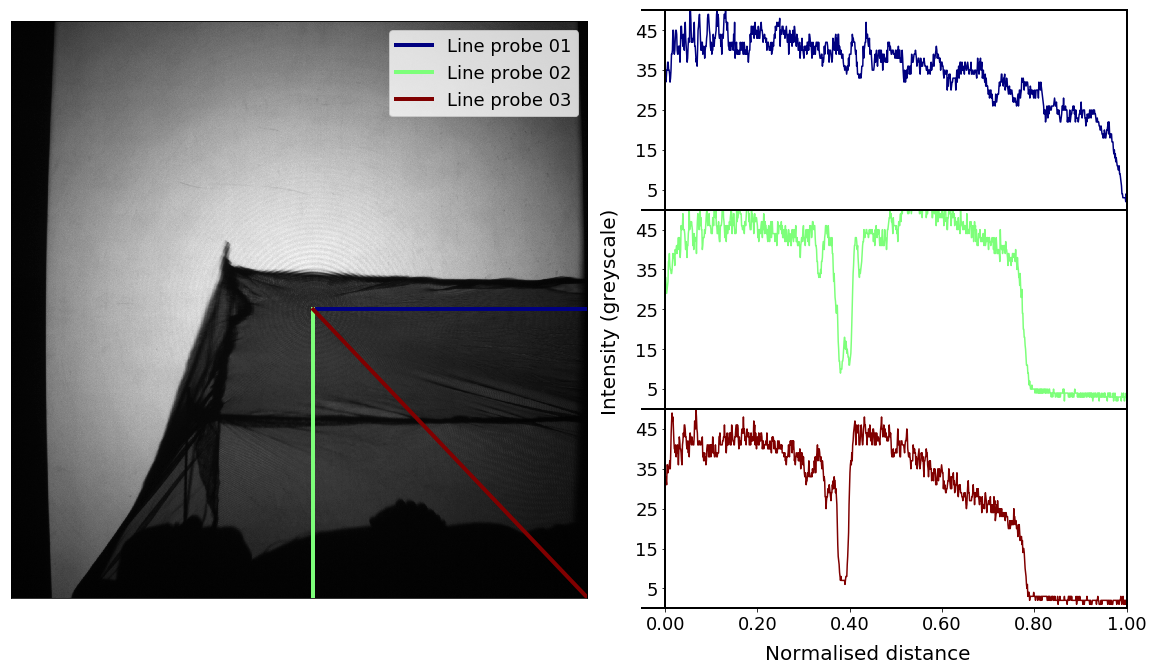

In [27]:
plotSpacialDist(lineList2,image3,imageFilename='backlit_dark.png',imageFolder='./Images/',wspace=0.15,yLabelPos=0.535,ylimit=[0,50])

In [28]:
pointList = []
point2 = np.array([np.floor(seq3.imageWidth/2),np.floor(seq3.imageHeight/4)])
pointList.append(point2)
point1 = np.array([np.floor(seq3.imageWidth/2),np.floor(seq3.imageHeight*3/4)])
pointList.append(point1)
point3 = np.array([np.floor(seq3.imageWidth*3/4),np.floor(seq3.imageHeight*3/4)])
pointList.append(point3)
point4 = np.array([np.floor(seq3.imageWidth*3/4),np.floor(seq3.imageHeight/4)])
pointList.append(point4)

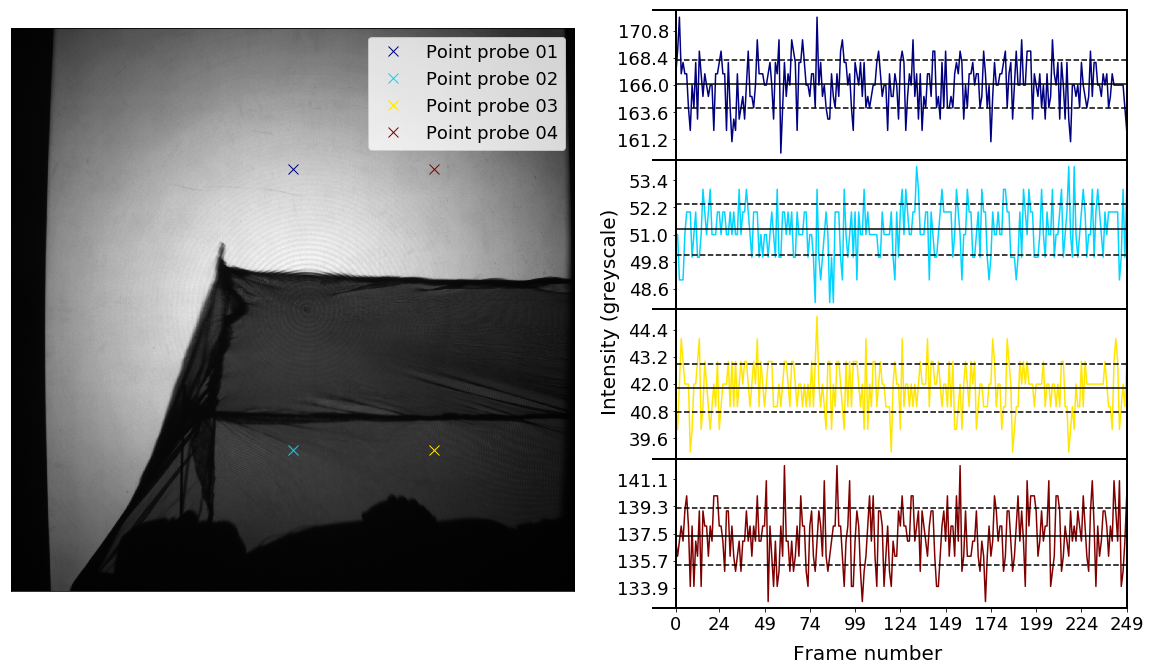

In [29]:
backlitTempStats=plotTemporalDist(pointList,images3,'backlit_temporal.png',imageFolder='./Images/',wspace=0.2,yLabelPos=0.535)

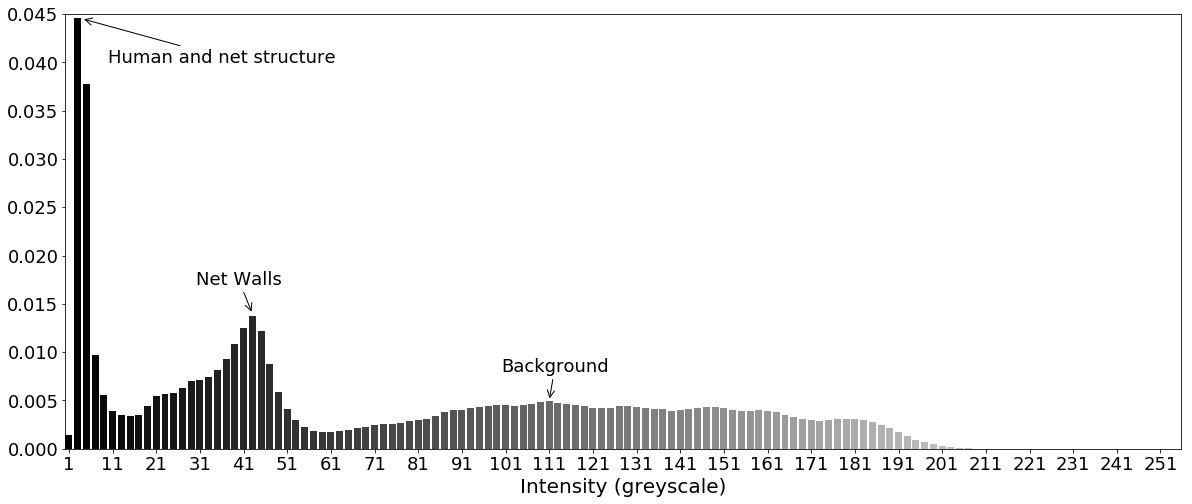

In [30]:
annCoords = ['Human and net structure',(4,0.0445),(10,0.040),'Net Walls',(43,0.014),(30,0.017),'Background',(111,0.005),(100,0.008)]
plotImageHistogram(image3,aCrd=annCoords,imageFilename='backlit_histogram.png',imageFolder='./Images/')

In [31]:
imagesB1 = []
imagesB1.append(seq3.readFrame(131).numpy())
imagesB1.append(seq3.readFrame(158).numpy())
imagesB1.append(seq3.readFrame(275).numpy())
imagesB1 = np.stack(imagesB1,axis=0)

pointsList=[]
pointsList.append(np.array([163,839,20,0]))
pointsList.append(np.array([461,669,20,1]))
pointsList.append(np.array([1184,704,20,2]))

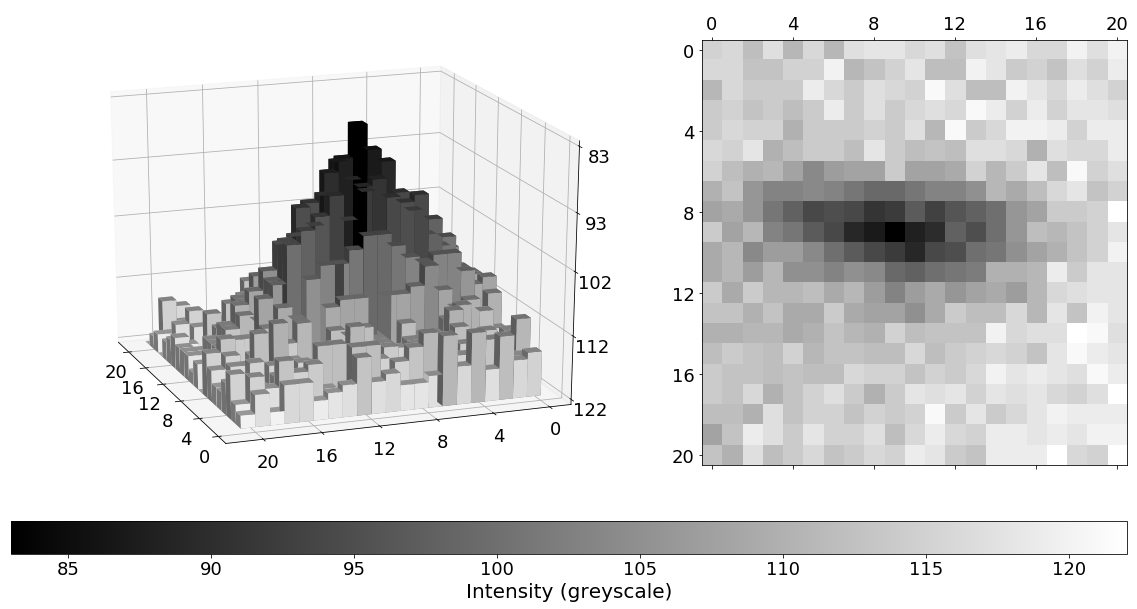

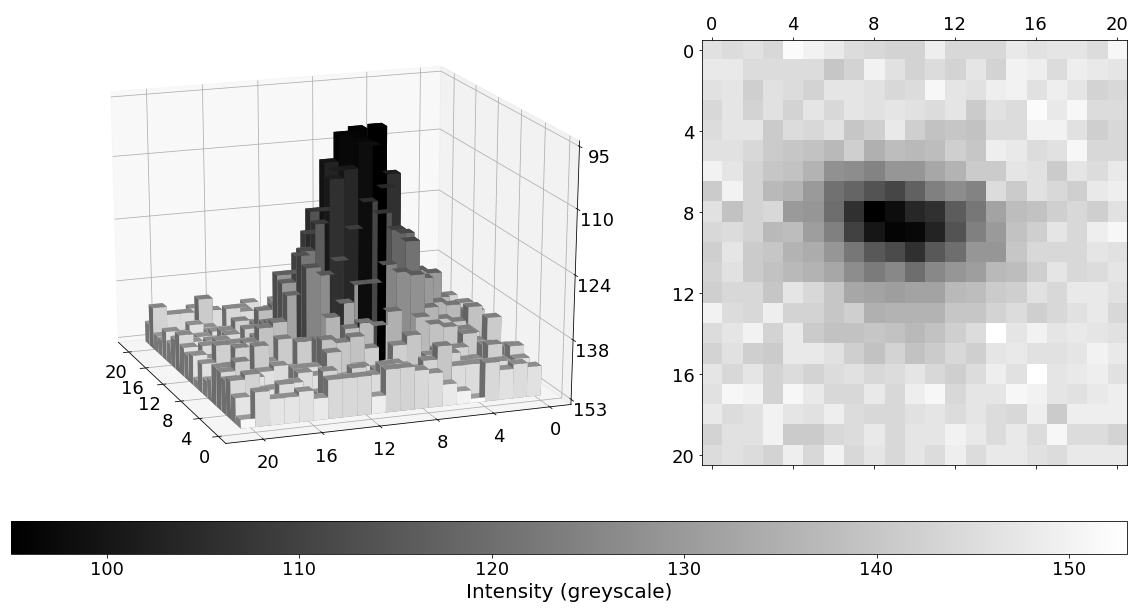

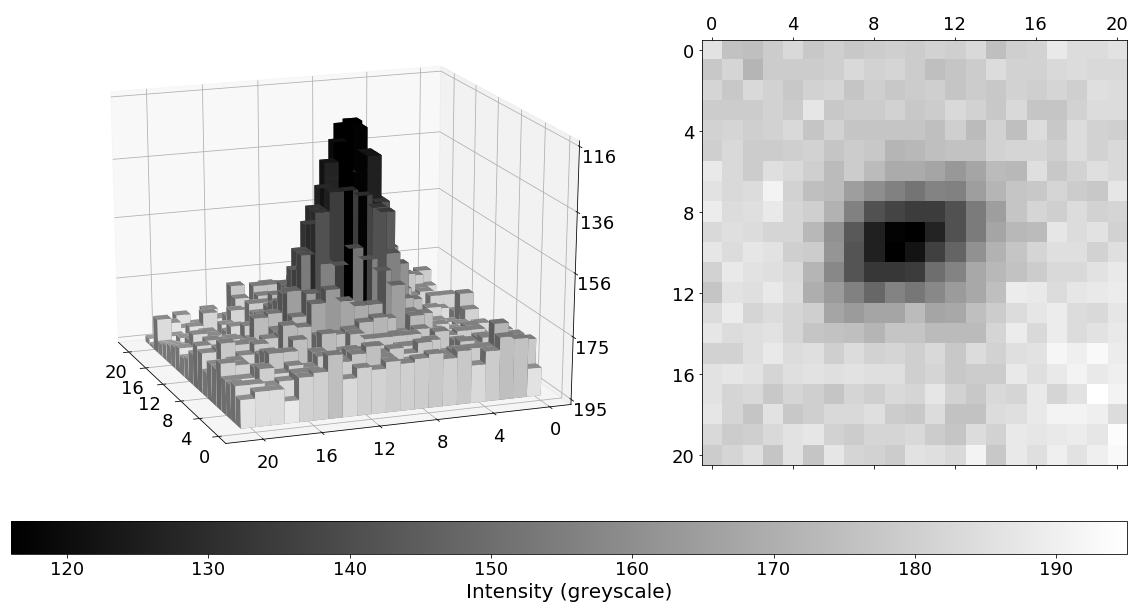

In [32]:
dvCentres_gates_bright = plotBlob3DMap(pointsList,imagesB1,imageBasename='backlit_bright',imageFolder='./Images/',doPixels=True)

In [33]:
imagesB1 = []
imagesB1.append(seq3.readFrame(345).numpy())
imagesB1.append(seq3.readFrame(348).numpy())
imagesB1.append(seq3.readFrame(362).numpy())
imagesB1 = np.stack(imagesB1,axis=0)

pointsList=[]
pointsList.append(np.array([1642,1021,20,0]))
pointsList.append(np.array([1690,1040,20,1]))
pointsList.append(np.array([1978,1243,20,2]))

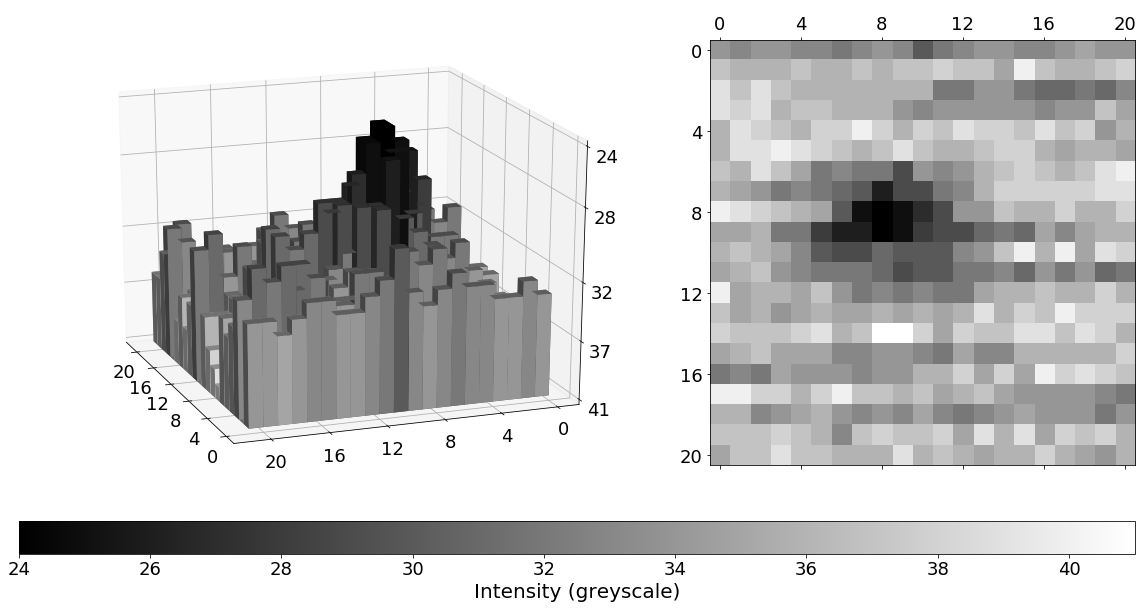

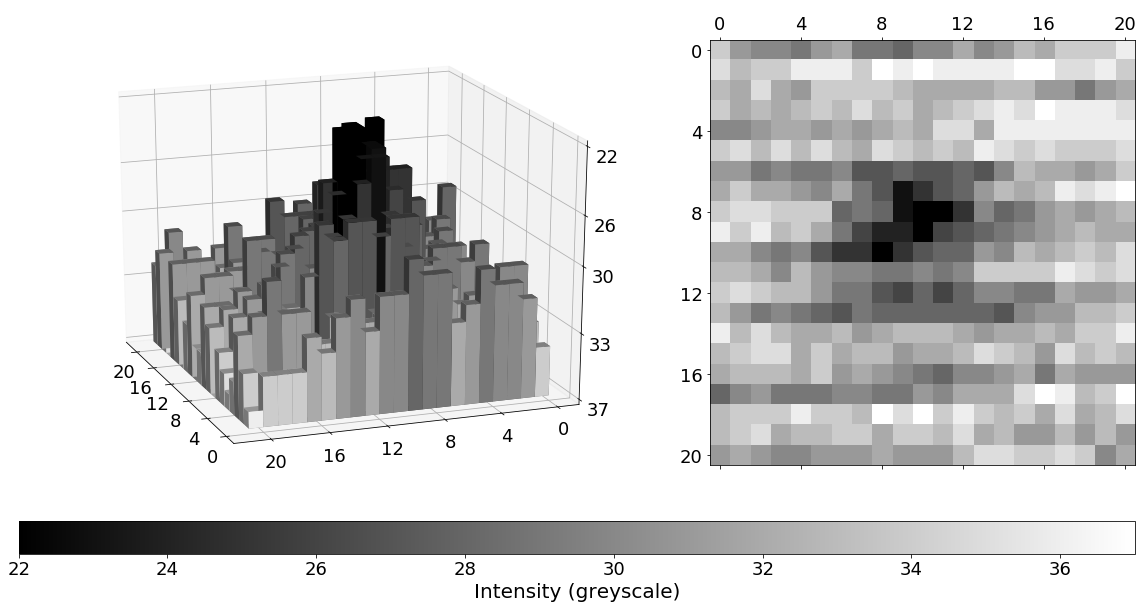

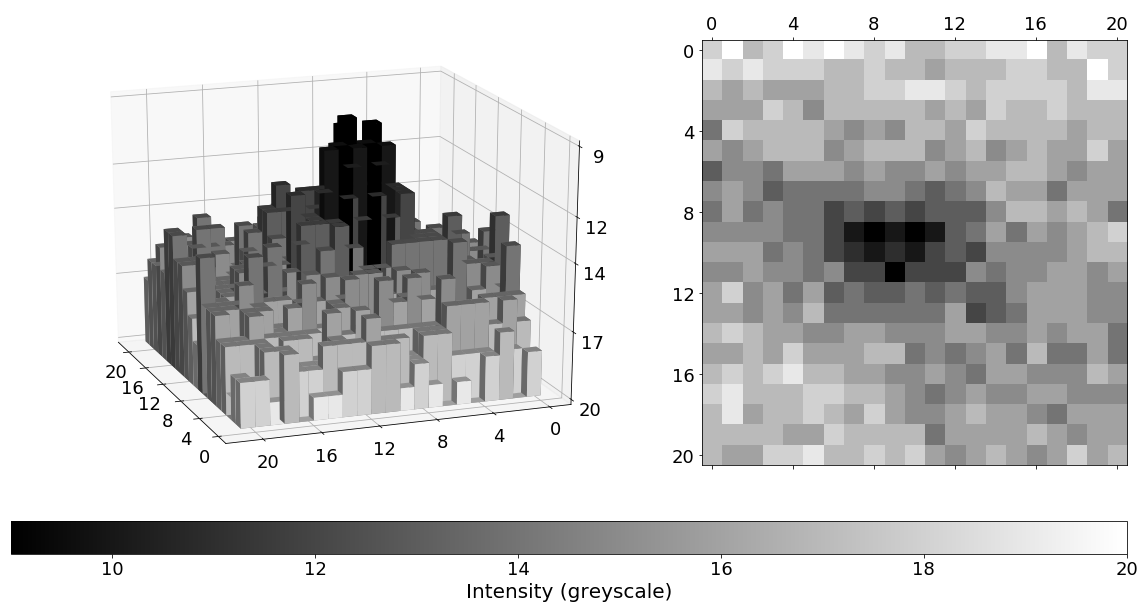

In [34]:
dvCentres_gates_net = plotBlob3DMap(pointsList,imagesB1,imageBasename='backlit_net',imageFolder='./Images/',doPixels=True)

In [35]:
labels=['Point Probe 01','Point Probe 02','Point Probe 03','Point Probe 04']
for label,gMean,gStr,gRange,bMean,bStd,bRange in zip(labels,*gatesTempStats,*backlitTempStats):
    print(f'{label} & {gMean:.1f} & {gStr:.2f} & {gRange} & {bMean:.1f} & {bStd:.2f} & {bRange} \\\\ \n\hline')

Point Probe 01 & 178.5 & 1.59 & 9 & 166.1 & 2.11 & 12 \\ 
\hline
Point Probe 02 & 34.7 & 0.97 & 4 & 51.2 & 1.14 & 6 \\ 
\hline
Point Probe 03 & 29.6 & 0.78 & 5 & 41.8 & 1.06 & 6 \\ 
\hline
Point Probe 04 & 164.2 & 1.73 & 10 & 137.3 & 1.89 & 9 \\ 
\hline
